In [3]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [4]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [5]:
import pandas as pd
reviews_cons = pd.read_csv("../input/pros-an-cons/pros_cons/IntegratedCons.txt" , sep='\n')
reviews_pros = pd.read_csv("../input/pros-an-cons/pros_cons/IntegratedPros.txt" , sep='\n')

reviews_cons.columns = ['sentence']
reviews_pros.columns = ['sentence']

train_input_c=[]
for val in reviews_cons['sentence']:
    sentence = str(val).replace('<Cons>','').replace('</Cons>','').strip()
    train_input_c.append(sentence)
    
train_input_p=[]
for val in reviews_pros['sentence']:
    sentence = str(val).replace('<Pros>','').replace('</Pros>','').strip()
    train_input_p.append(sentence)

reviews_cons = pd.DataFrame({'sentence':train_input_c})
reviews_cons.loc[:,'label'] = [0 for i in range(len(reviews_cons))]
print(reviews_cons)

reviews_pros = pd.DataFrame({'sentence':train_input_p})
reviews_pros.loc[:,'label'] = [1 for i in range(len(reviews_pros))]
print(reviews_pros)

reviews=reviews_cons.append(reviews_pros)
reviews_suffled = reviews.sample(frac=1).reset_index(drop=True) 

print(reviews_suffled['sentence'][:32000])

train_label=[r[1] for r in reviews_suffled.to_numpy().tolist()]

                                                sentence  label
0                             Eats...no, GULPS batteries      0
1      Awkward ergonomics, no optical viewfinder, sho...      0
2                  Battery eating beast/slow to recharge      0
3                      power runs out before pictures do      0
4                   Slow, high battery consumption rate.      0
...                                                  ...    ...
22929  Little bulky but easily fits in pocket....othe...      0
22930  LEMONNNNNNN. size, weight, everything I mentio...      0
22931  Lackluster mediocrity, poorly thought through ...      0
22932     Large size, minor design flaws (not ergonomic)      0
22933             Bulky, no video camera, texting system      0

[22934 rows x 2 columns]
                                                sentence  label
0      Digital is where it's at...down with developin...      1
1      Good image quality, 3x optical zoom, macro mod...      1
2      Awesome

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((reviews_suffled['sentence'][:32000].to_numpy(),np.array(train_label[:32000])))
train_dataset = train_dataset.shuffle(1000).repeat(1).batch(20)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

In [7]:
vaild_dataset = tf.data.Dataset.from_tensor_slices((reviews_suffled['sentence'][32000:40000].to_numpy(),np.array(train_label[32000:40000])))
vaild_dataset = vaild_dataset.shuffle(1000).repeat(1).batch(10)

In [8]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [b'Dimensions, Features'
 b'Power switch hard to use. Viewfinder a little off-center.'
 b'Weak Speakerphone, small size, costly downloads'
 b'Fast printing, easy set-up, cheap ink.'
 b'Good price on a personal laser printer. Crisp printing.'
 b'Rock reliable, extendable antenna, inexpensive, good performance'
 b'Stylish, Reasonable Amount of Features, Melody Composer, One Touch Internet, Light, Great Quality, Computer Connection'
 b'This phone can do mp3,FULL movies,and just about everything but cook you dinner.'
 b'not the most attractive' b'small, simple, cheap' b'low battery life'
 b'Inexpensive, Well rounded, Good Battery Life'
 b'Learning curve is steep for advanced features.  Lens cap not attached.  Worthless software package.'
 b'Sometimes weak signal, even on interstates . . .'
 b'User friendly, even my 6 year old can use it.'
 b"Some photos had red eye, doesn't come with carrying case"
 b'Worked well , while it worked.'
 b'It takes awhile sometimes to take a photo.'
 b'

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

encoder.adapt(train_dataset.map(lambda text, label: text))

2021-12-05 11:49:54.736551: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [10]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)
vocab[:20]

array(['', '[UNK]', 'to', 'and', 'quality', 'use', 'great', 'easy', 'of',
       'a', 'the', 'battery', 'good', 'no', 'small', 'for', 'life', 'not',
       'is', 'price'], dtype='<U13')

In [11]:
print(example[:3])
encoded_example = encoder(example)[:3].numpy()
encoded_example

tf.Tensor(
[b'Dimensions, Features'
 b'Power switch hard to use. Viewfinder a little off-center.'
 b'Weak Speakerphone, small size, costly downloads'], shape=(3,), dtype=string)


array([[  1,  20,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [198, 706,  82,   2,   5, 225,   9,  54,   1,   0,   0,   0,   0,
          0,   0],
       [153, 133,  14,  22, 564, 875,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Dimensions, Features'
Round-trip:  [UNK] features             

Original:  b'Power switch hard to use. Viewfinder a little off-center.'
Round-trip:  power switch hard to use viewfinder a little [UNK]      

Original:  b'Weak Speakerphone, small size, costly downloads'
Round-trip:  weak speakerphone small size costly downloads         



In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True, True]


In [15]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00344436]


In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.00344436]


In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [18]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=vaild_dataset,
                    steps_per_epoch=200,
                    validation_steps=30)

Epoch 1/5
200/200 [==============================] - 30s 76ms/step - loss: 0.6798 - accuracy: 0.5070 - val_loss: 0.6053 - val_accuracy: 0.6233
Epoch 2/5
200/200 [==============================] - 9s 46ms/step - loss: 0.4409 - accuracy: 0.8165 - val_loss: 0.3275 - val_accuracy: 0.8733
Epoch 3/5
200/200 [==============================] - 9s 46ms/step - loss: 0.3093 - accuracy: 0.8855 - val_loss: 0.2765 - val_accuracy: 0.8967
Epoch 4/5
200/200 [==============================] - 10s 50ms/step - loss: 0.2678 - accuracy: 0.8960 - val_loss: 0.2210 - val_accuracy: 0.8900
Epoch 5/5
200/200 [==============================] - 9s 45ms/step - loss: 0.2616 - accuracy: 0.8978 - val_loss: 0.2054 - val_accuracy: 0.9167


In [19]:
test_loss, test_acc = model.evaluate(vaild_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

800/800 [==============================] - 8s 9ms/step - loss: 0.2364 - accuracy: 0.9139
Test Loss: 0.23643267154693604
Test Accuracy: 0.9138749837875366


(0.0, 0.7035498425364495)

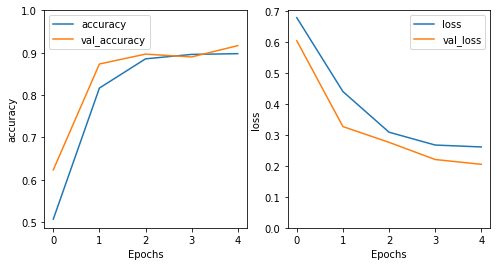

In [20]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [21]:
sample_text="i love it"
predictions = model.predict(np.array([sample_text]))
print("sentence:",sample_text)
predictions = tf.nn.sigmoid(predictions)
if predictions.numpy()[0][0] >= 0.5:
    print("result:","positive(1)")
else:
    print("result:","negative(0)")
    
print(predictions.numpy()[0][0])

sentence: i love it
result: positive(1)
0.62277025
